In [1]:
import canonical_toolkit as ctk
import pandas as pd
import numpy as np

Loading in the 5 fuda robots

In [2]:
hand_picked_5 = pd.read_csv('__data__/hand_picked_5.csv')['fuda_aligned'].to_list()

Loading in last gen of morphological fuda method ea

In [3]:
fuda_method = pd.read_csv('__data__/ariel_lastgen/ea_fuda.csv')['ctk_string'].to_list()

In [4]:
# UNCOMMENT TO SEE THE FINAL POPULATION PLOTS - takes +- 3 min to save, +- 30 seconds to load in
# ctk.snapshot_saver([ctk.node_from_string(ind).to_graph() for ind in fuda_method], save_folder='__data__/ariel_lastgen/ea_fuda_img')
# plotter = ctk.GridPlotter()
# plotter.add_image_data(data_folder='__data__/ariel_lastgen/ea_fuda_img', shape=(25, 20))

Loading in last gen of ctk method ea

In [5]:
ctk_method = pd.read_csv('__data__/ariel_lastgen/ea_ctk_1.csv')['ctk_string'].to_list()

In [6]:
# UNCOMMENT TO SEE THE FINAL POPULATION PLOTS - takes +- 3 min to save, +- 30 seconds to load in
# ctk.snapshot_saver([ctk.node_from_string(ind).to_graph() for ind in fuda_method], save_folder='__data__/ariel_lastgen/ea_ctk_img')
# plotter = ctk.GridPlotter()
# plotter.add_image_data(data_folder='__data__/ariel_lastgen/ea_ctk_img', shape=(25, 20))

the fuda fitness function

In [7]:
def fuda_novelty(str_population: list[str], pre_selected: list[str], n_select: int = 1):
    import numpy as np
    import canonical_toolkit as ctk
    from ariel_experiments.characterize.individual import (
        analyze_branching, analyze_coverage, analyze_joints,
        analyze_number_of_limbs, analyze_proportion_literature, analyze_symmetry,
    )
    from ariel_experiments.characterize.population import get_raw_population_properties
    from sklearn.metrics import pairwise_distances
    from ariel_experiments.characterize.individual import analyze_branching, analyze_coverage, analyze_joints, analyze_number_of_limbs, analyze_proportion_literature, analyze_symmetry

    analysers = [
        analyze_branching, analyze_number_of_limbs, analyze_coverage,
        analyze_joints, analyze_proportion_literature, analyze_symmetry,
    ]
    pop_graphs = [ctk.node_from_string(ind).to_graph() for ind in str_population]
    pre_graphs= [ctk.node_from_string(ind).to_graph() for ind in pre_selected]
    
    all_graphs = pop_graphs + pre_graphs
    
    documents = get_raw_population_properties(all_graphs, analysers, n_jobs=1, hide_tracker=True)
    X = np.array(list(documents.values())).T    
    dist_matrix = pairwise_distances(X, metric="euclidean")

    P = len(str_population)
    S = len(pre_selected)
    new_matrix = dist_matrix[-S:, :P]
    
    min_similarities = new_matrix.min(axis=0) # minimum distance corresponds to closest neighbour
    lowest_indices = np.argsort(min_similarities)[-n_select:] # select the maximum value. so the one who has the most distanc to knn
    selected_strings = [str_population[i] for i in lowest_indices]

    return selected_strings

ctk fitness function

In [8]:
def ctk_novelty(str_population: list[str], pre_selected: list[str], n_select: int = 1, k: int = 1):
    pop_nodes = [ctk.node_from_string(ind) for ind in str_population]
    pre_nodes = [ctk.node_from_string(ind) for ind in pre_selected]
    
    all_nodes = pop_nodes + pre_nodes
    space_config = ctk.SimilaritySpaceConfig(max_hop_radius=3)
    series = ctk.series_from_node_population(all_nodes, space_config)
        
    matrix = series.map('cosine_similarity').aggregate().normalize_by_radius()
    
    P = len(str_population)
    S = len(pre_selected)
    
    new_matrix = matrix[-S:, :P]
    partitioned = np.partition(new_matrix, -k, axis=0)
    top_k_similarities = partitioned[-k:, :]

    
    sum_similarities = np.sum(top_k_similarities, axis=0)
    lowest_indices = np.argsort(sum_similarities)[:n_select] # minimize to get indvididual who is furthest away (most distance knn)
    
    selected_strings = [str_population[i] for i in lowest_indices]
    
    return selected_strings

In [9]:
test_suite_fuda = hand_picked_5.copy()
while len(test_suite_fuda) < 20:
    new_individual = fuda_novelty(
        str_population=fuda_method,
        pre_selected=test_suite_fuda,
    )
    test_suite_fuda.extend(new_individual)
    
pd.DataFrame(test_suite_fuda).to_csv('__data__/ariel_zoo/fuda_20.csv', index=False, header=['ctk_string'])

In [10]:
ctk.snapshot_saver([ctk.node_from_string(ind).to_graph() for ind in test_suite_fuda], save_folder='__data__/ariel_zoo/fuda_20/img')

Output()

Saved 20/20 snapshots to __data__/ariel_zoo/fuda_20/img

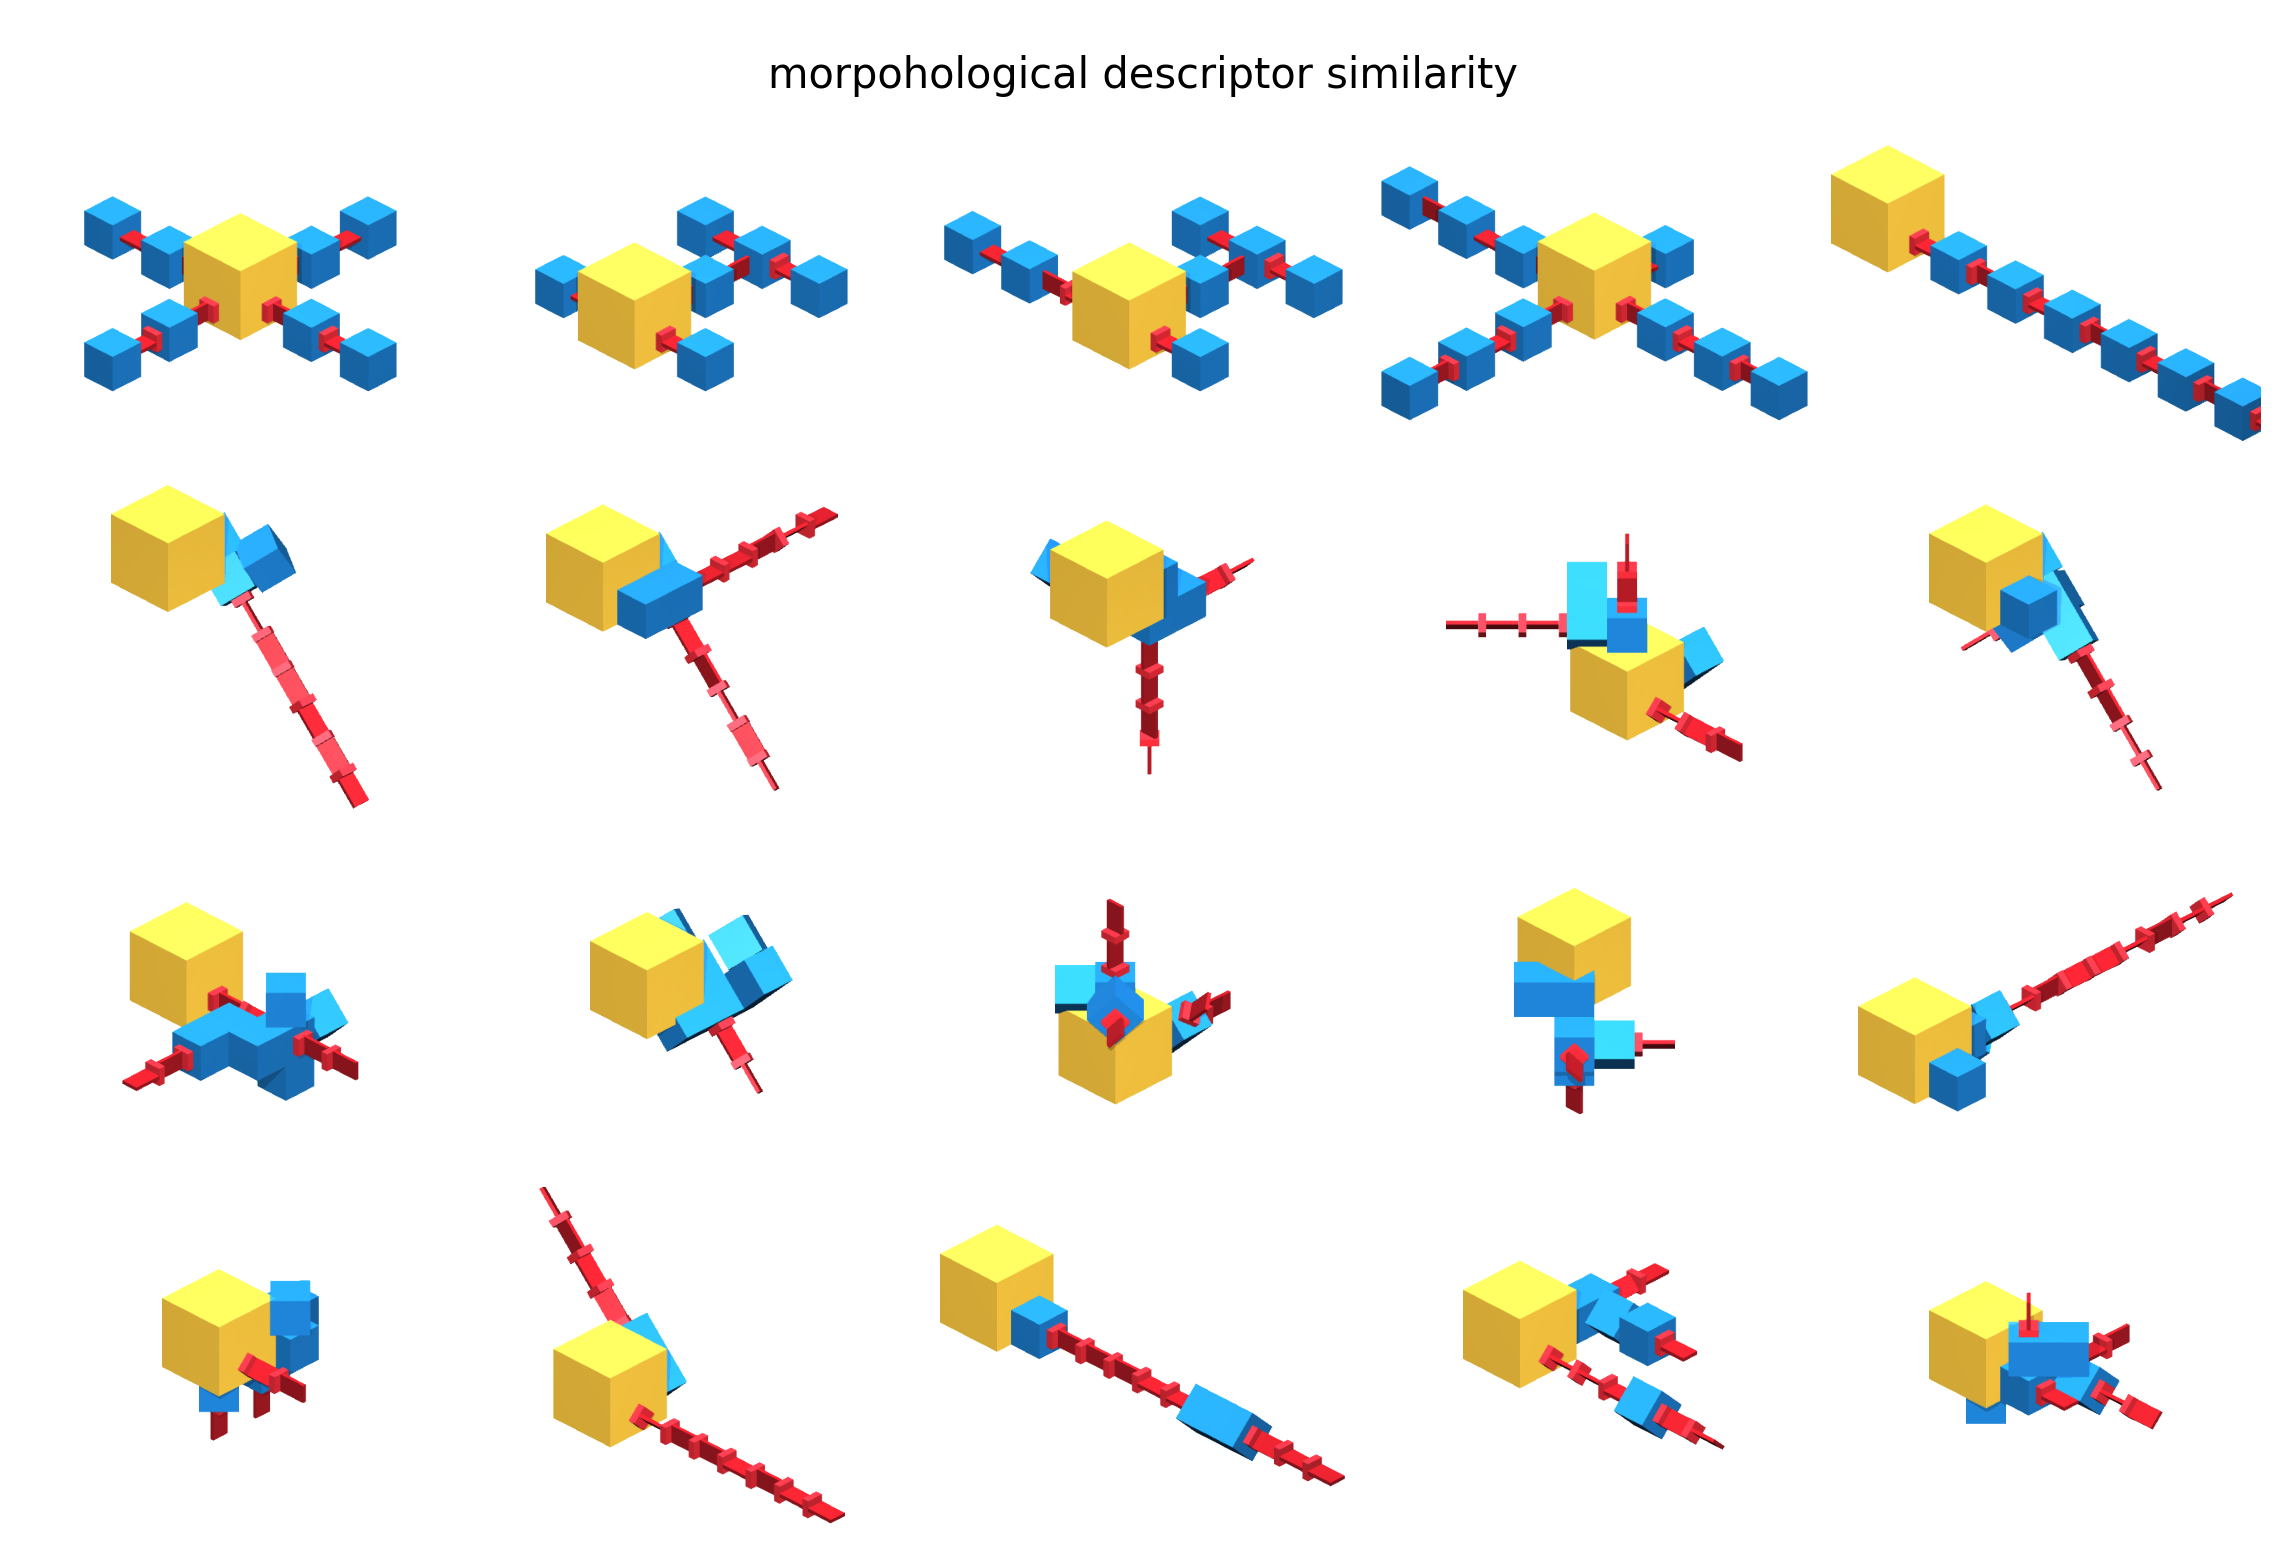

In [11]:
plotter = ctk.GridPlotter()
plotter.add_image_data(data_folder='__data__/ariel_zoo/fuda_20/img', shape=(4, 5))
plotter.suptitle('morpohological descriptor similarity')
plotter.config.margin = (0.3,0,0,0)
plotter.show()

In [12]:
test_suite_ctk = hand_picked_5.copy()
while len(test_suite_ctk) < 20:
    new_individual = ctk_novelty(
        str_population=ctk_method,
        pre_selected=test_suite_ctk,
    )
    test_suite_ctk.extend(new_individual)

pd.DataFrame(test_suite_ctk).to_csv('__data__/ariel_zoo/ctk_20.csv', index=False, header=['ctk_string'])

In [13]:
ctk.snapshot_saver([ctk.node_from_string(ind).to_graph() for ind in test_suite_ctk], save_folder='__data__/ariel_zoo/ctk_20/img')

Output()

Saved 20/20 snapshots to __data__/ariel_zoo/ctk_20/img

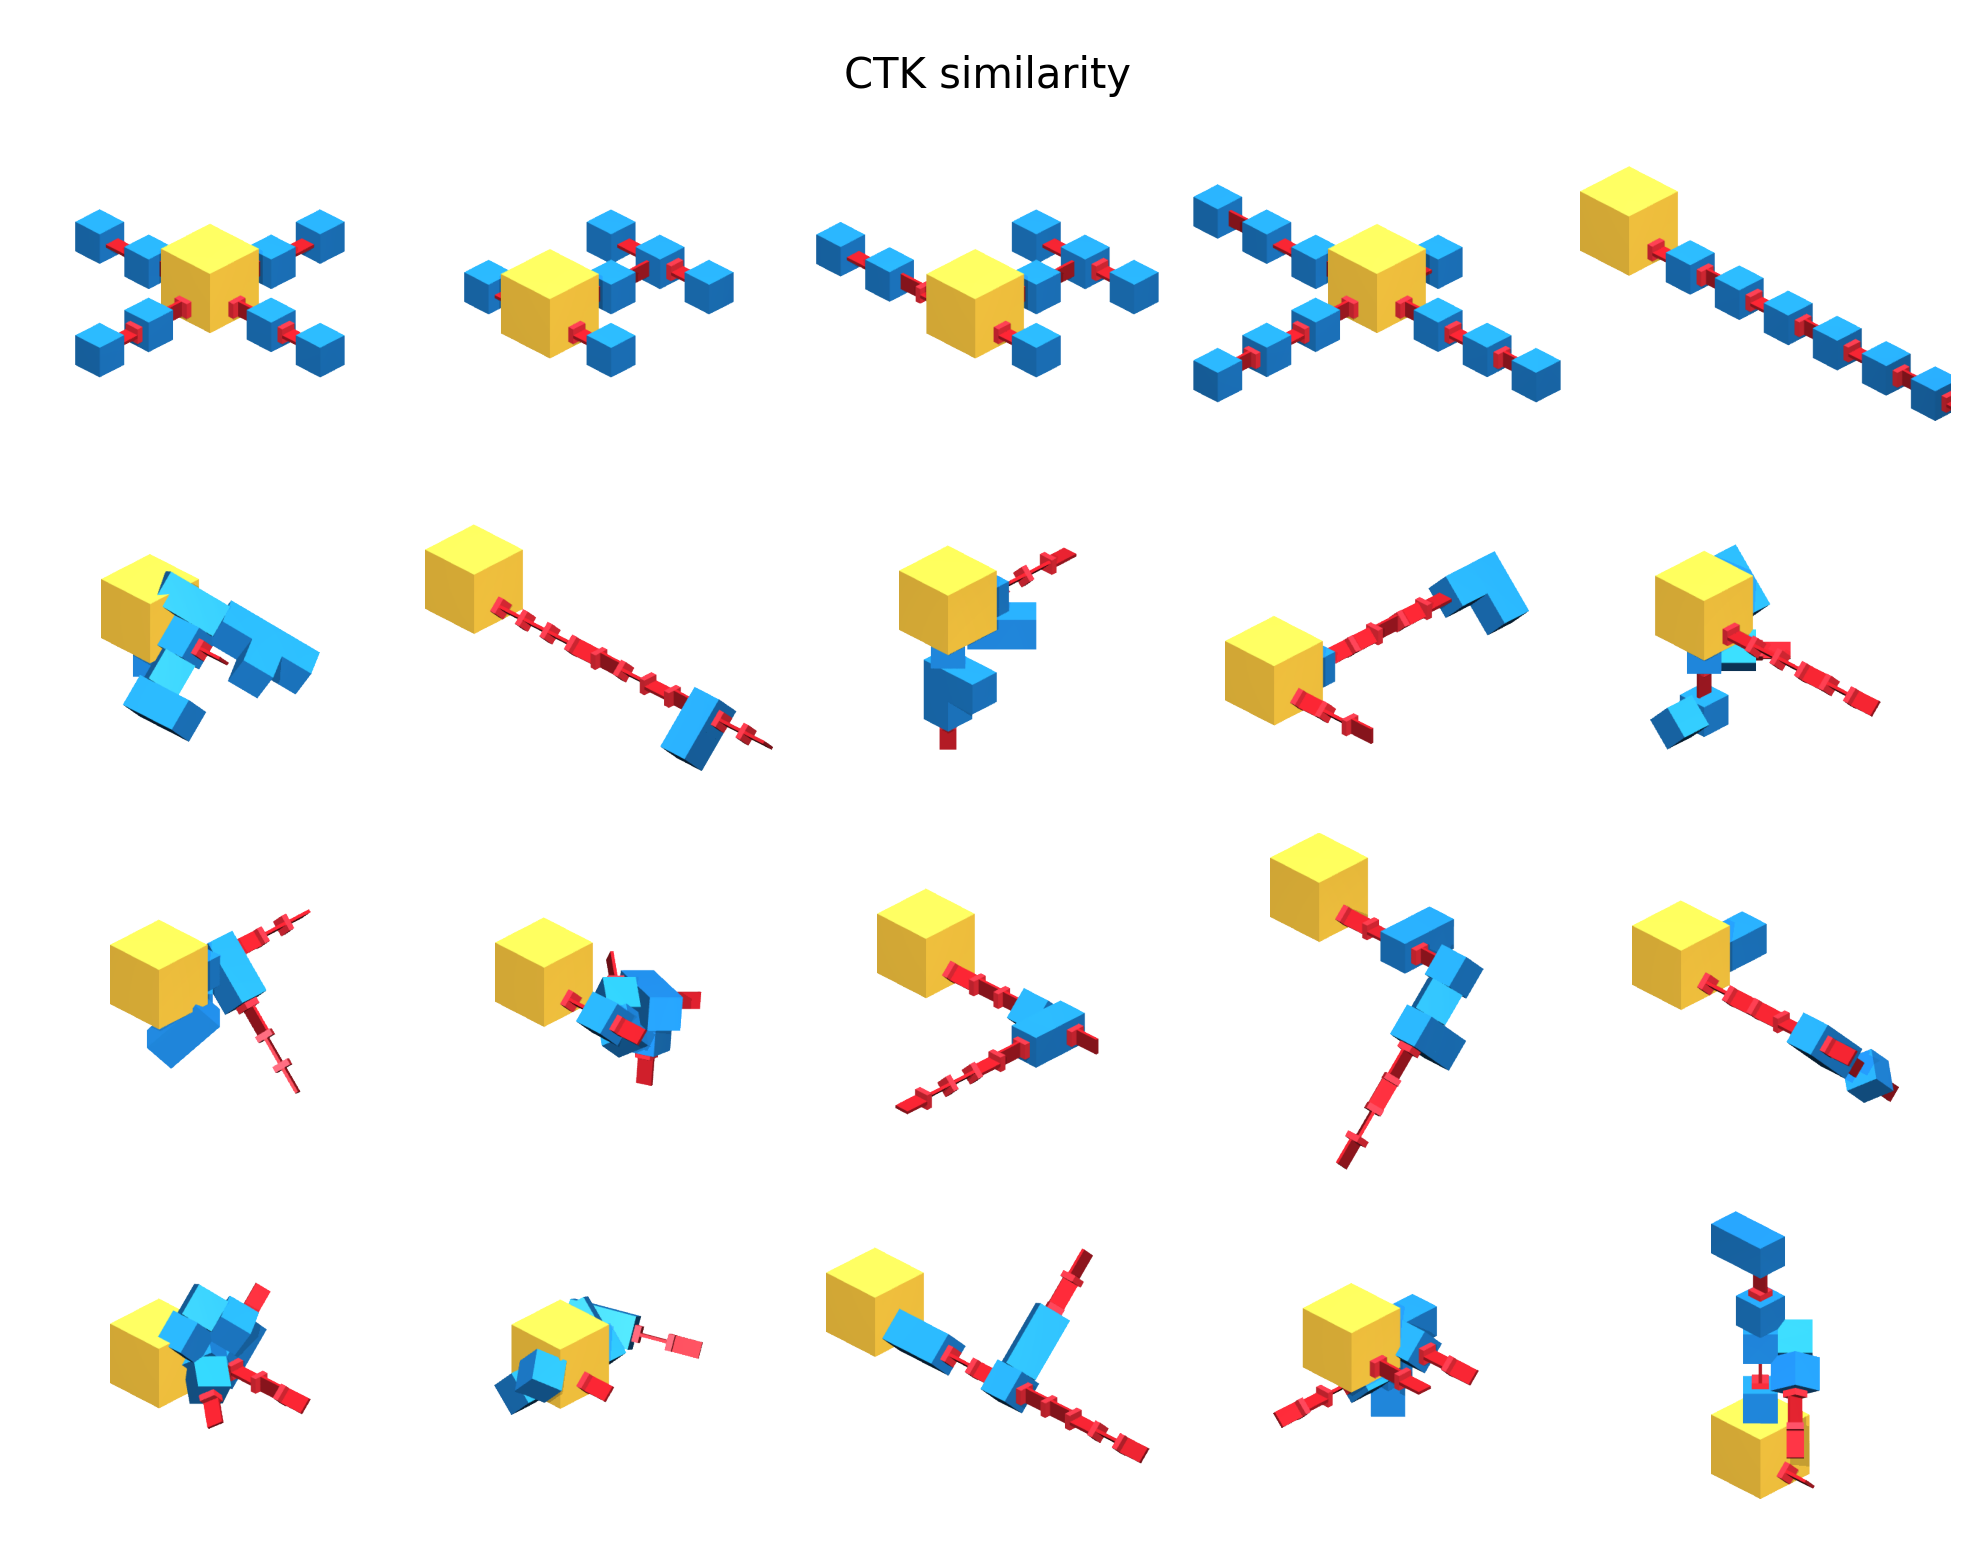

In [14]:
plotter = ctk.GridPlotter()
plotter.add_image_data(data_folder='__data__/ariel_zoo/ctk_20/img', shape=(4, 5))
plotter.suptitle('CTK similarity')
plotter.config.margin = (0.3,0,0,0)
plotter.show()